# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [33]:
# System imports
from os import path
import math
import random

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# modify to where you store your project data including utils
datadir = "/content/drive/My Drive/cs445_projects/proj4/" 

utilfn = datadir + "utils"
# !cp -r "$utilfn" .
samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter



### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

In [4]:
imdir = 'samples/DCIM3'
imfns = ['0010.jpg', '0020.jpg', '0040.jpg', '0080.jpg', '0160.jpg']
exposure_times = [1/10.0, 1/20.0, 1/40.0, 1/80.0, 1/160.0]

ldr_images = []
for f in np.arange(len(imfns)):
    im = read_image(imdir + '/' + imfns[f])
    if f==0:
        imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
        ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
    ldr_images[f] = cv2.resize(im, (imsize, imsize))

background_image_file = imdir + '/' + 'empty.jpg'
background_image = read_image(background_image_file)



### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [5]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    2) Return average of above images
    
    
    For further explanation, please refer to problem page for how to do it.
      
    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array represending log irradiances
            for each exposures
            
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)
    
    #set up
    ldr_c = ldr_images*255
    
    hdr_image = np.zeros((H,W,C))
    log_irradiances = np.zeros((N,H,W,C))
    
    #each channel
    for i in range(N):
        #divide
        temp=ldr_c[i, :, :, :] / exposures[i]
        
        hdr_image = hdr_image+temp
        with np.errstate(divide='ignore'):
            log_irradiances[i, :, :, :] = np.log(temp)
    
    #average
    hdr_image = hdr_image/ N        
    
    return hdr_image, log_irradiances



In [6]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays. 
    Three suggestions to try: 
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example) 
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package 
    '''

    #copy and float type
    hdr_image = im_hdr.copy().astype(np.float32)

    tonemapDrago = cv2.createTonemapDrago(1.0)
    ldrDrago = tonemapDrago.process(hdr_image)
    
  
    #replace nan
    nan_mask = np.isnan(ldrDrago)
    ldrDrago[nan_mask] =0

    #replace inf
    inf_mask = np.isinf(ldrDrago)
    ldrDrago[inf_mask] =255
    
    
    im2_8bit = np.clip(ldrDrago * 255, 0, 255).astype('uint8')
    
    fig = plt.figure()
    plt.axis('off')
    plt.imshow(im2_8bit)


HDR Image


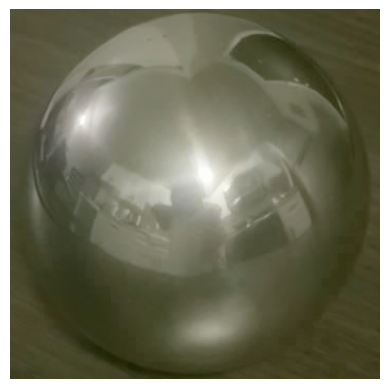

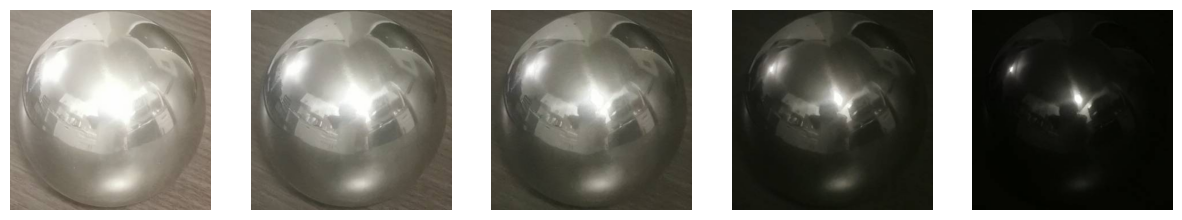

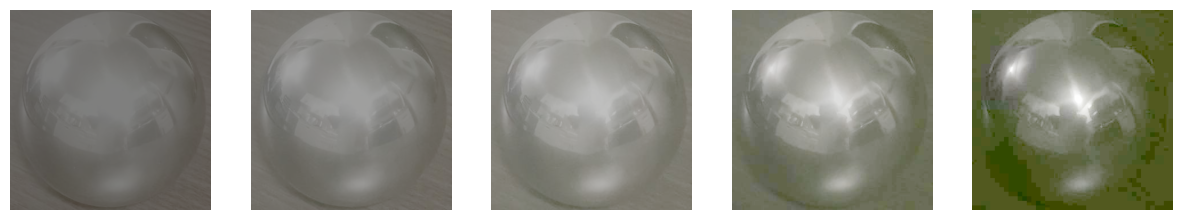

In [7]:

# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image/255, 'images/outputs/naive_hdr.hdr')

# display HDR image
print('HDR Image')
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)


### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [8]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    '''
    
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # weight
    w = lambda z: (128 - np.abs(z - 128))/128
    
    #set up
    ldr_c = ldr_images*255
    
    hdr_image = np.zeros((H,W,C))
    log_irradiances = np.zeros((N,H,W,C))
    
    #divide and weight average
    weightall = 0
    #each channel
    for i in range(N):
        weight = w(ldr_c[i,:,:,:])
        
        hdr_image = hdr_image+(weight*ldr_c[i,:,:,:])/exposure_times[i]
        weightall = weightall+weight
        
    hdr_image = hdr_image/ weightall
    
    
    return hdr_image


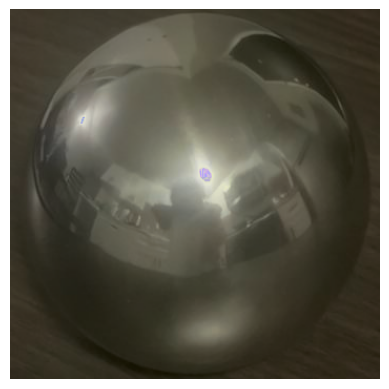

In [9]:
# get HDR image, log irradiance
weighted_hdr_image = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image/255, 'images/outputs/weighted_hdr.hdr')

# display HDR image
display_hdr_image(weighted_hdr_image)


Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.5710194903720999   Max ratio =  2.131700040151234


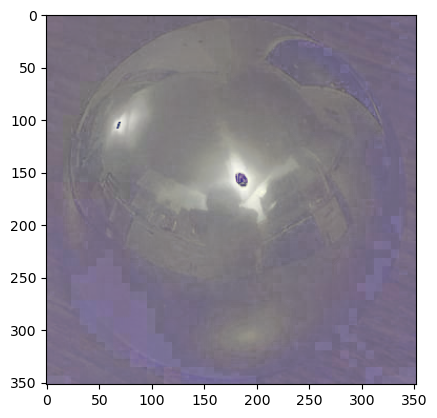

In [10]:
# display difference between naive and weighted 

log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [11]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight  
        'w' should be the weight of pixels from 0 to 255 for it to be indexed into by pixel (uint8) values.
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    #set up
    ldr_c = ldr_images*255
    
    hdr_image = np.zeros((H,W,C))
    log_irradiances = np.zeros((N,H,W,C))
    g_vals = np.zeros((3,256))
    
    #sample points number
    rc = 1000

    #sample from sphere area
    randrows = []
    randcols = []
    for count in range(rc):
        angle = random.uniform(0, 2 * math.pi)
        distance = (W//2-5) * math.sqrt(random.random())
        x = int(distance * math.cos(angle)+W//2)
        y = int(distance * math.sin(angle)+W//2)
        randrows.append(x)
        randcols.append(y)
        
        
    #set up
    Z = np.zeros((N,rc))
    B = np.log(exposure_times)
    w = lambda z: float((128 - np.abs(z - 128))/128)
    
    #compute weight
    wfunc = np.array([w(i) for i in range(256)], dtype=np.float32)
    
    #each channel
    for c in range(C):
        #each image exposure
        for n in range(N):
            #each point
            for i in range(rc):
                #store z
                Z[n,i] = ldr_c[n,randrows[i],randcols[i],c]
         
        #call gsolve and store g_vals
        g_vals[c], lE = gsolve(Z.astype("uint8"),B,lm,wfunc)
        
        #recover
        #each point
        for i in range(H):
            for j in range(W):
                #with weight calculation
                tempi =0
                wei =0
                for n in range(N):
                    #hdr and log irradiance
                    zij = int(ldr_c[n,i,j,c])
                    tempi = tempi + w(zij)*(g_vals[c][zij]-B[n])
                    wei = wei + w(zij)
                    
                    log_irradiances[n,i,j,c] = g_vals[c][zij] - B[n]
                    
                #average
                hdr_image[i,j,c] = tempi/wei
                


    #exponentiate hdr
    hdr_out=np.exp(hdr_image)
        
    return hdr_out, log_irradiances, g_vals

   

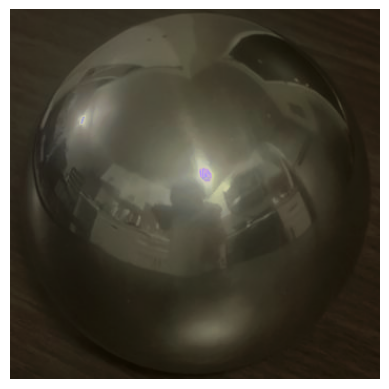

In [12]:
lm = 50
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)

# write HDR image to directory
write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)


The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.6341571406595677   Max ratio =  2.464510796749715


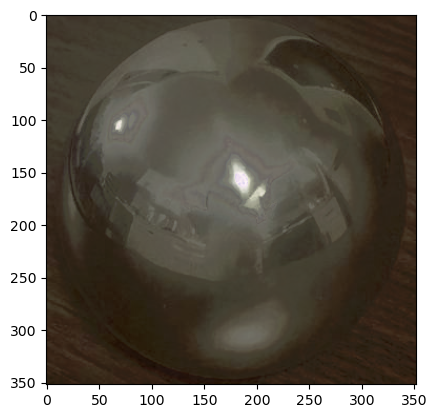

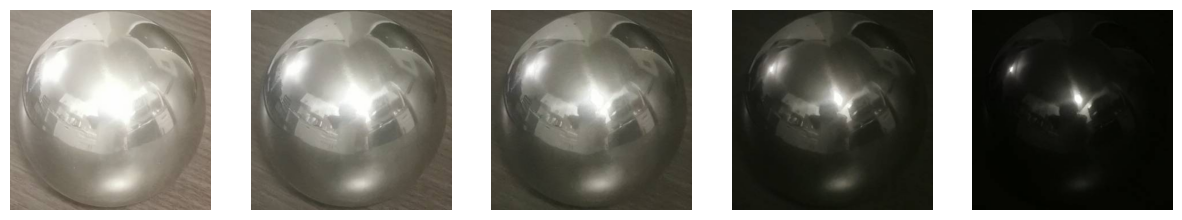

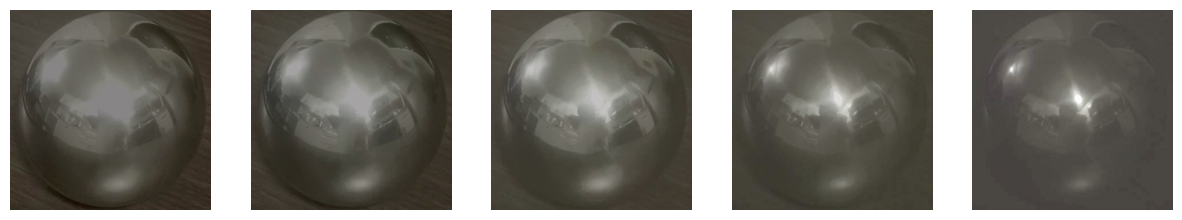

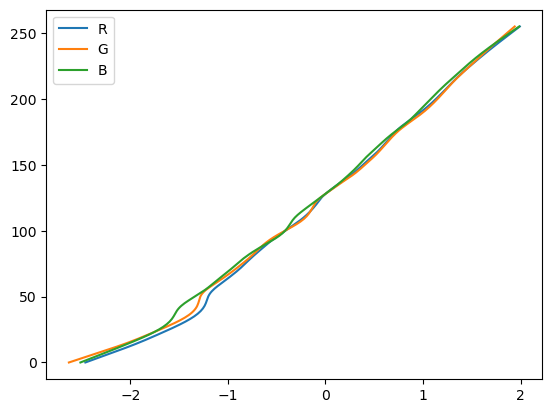

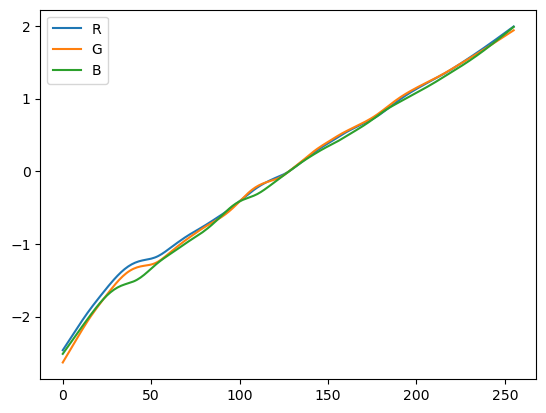

In [13]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  3.298 	avg RMS error =  0.312
weighted:	log range =  3.774 	avg RMS error =  0.291
calibrated:	log range =  4.925 	avg RMS error =  0.182


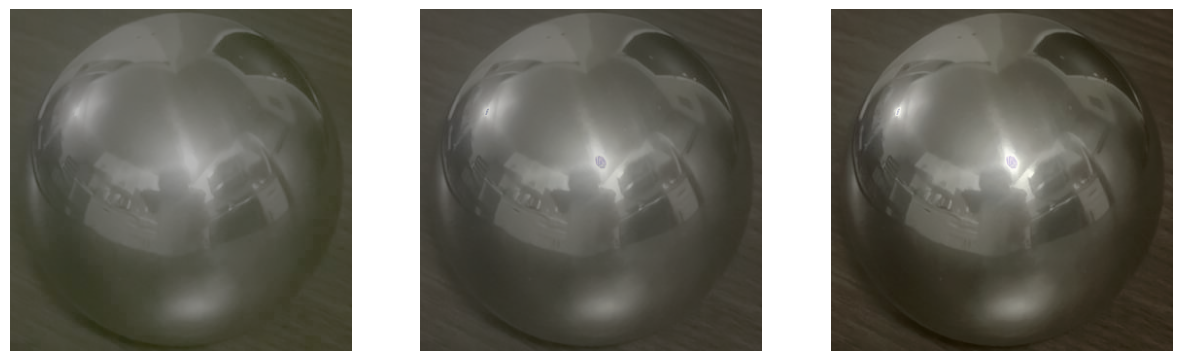

In [14]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
  N, H, W, C = ldr_images.shape
  w = 1-abs(ldr_images - 0.5)*2
  err = 0
  for n in np.arange(N):
    err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
  return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [31]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    
    Steps 3 and 4 are implemented for you with get_equirectangular_image

    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    #set up X,Y,Z
    X = np.repeat(((np.arange(0, W) - W/2) / (W/2)).reshape(1, -1), H, axis=0)
    Y = np.repeat(((np.arange(0, H) - H/2) / (H/2)).reshape(-1, 1), W, axis=1)

    Z = np.sqrt(np.maximum(0, 1-X*X-Y*Y))

    #mask XY according to Z>0
    X = np.where(Z > 0, X, 0)
    Y = np.where(Z > 0, Y, 0)

    #stack N
    N = np.stack((X, Y, Z), axis=-1)
    
    #view at V (0, 0, 1) 
    V = np.zeros((H,W,C))
    V[:,:,2] = np.where(Z > 0, -1, 0)
    
    #R = V - 2 * dot(V,N) * N
    R = V - 2 * np.expand_dims(np.sum(V * N, axis=-1), axis=-1) * N
    
        
    plt.imshow((N+1)/2)
    plt.show()
    plt.imshow((R+1)/2)
    plt.show()

    equirectangular_image = get_equirectangular_image(R, hdr_image)
    return equirectangular_image

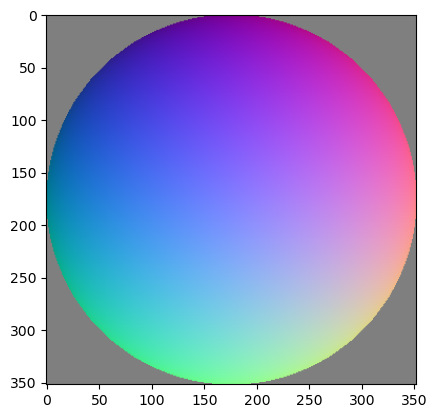

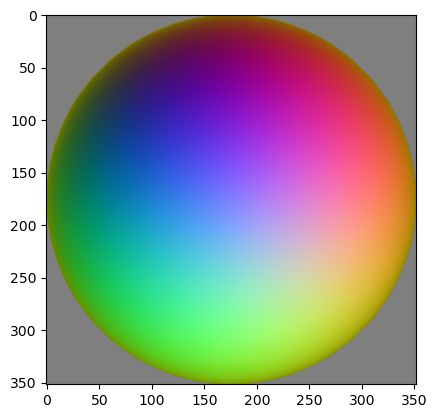

<Figure size 1500x1500 with 0 Axes>

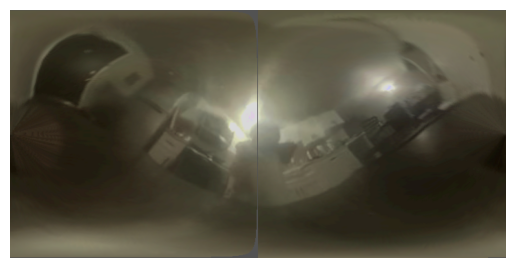

In [32]:
hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdr.hdr')
eq_image = panoramic_transform(hdr_mirrorball_image)

write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')

plt.figure(figsize=(15,15))
display_hdr_image(eq_image)


---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [17]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/proj4_objects.png')
E = read_image('images/proj4_empty.png')
M = read_image('images/proj4_mask.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

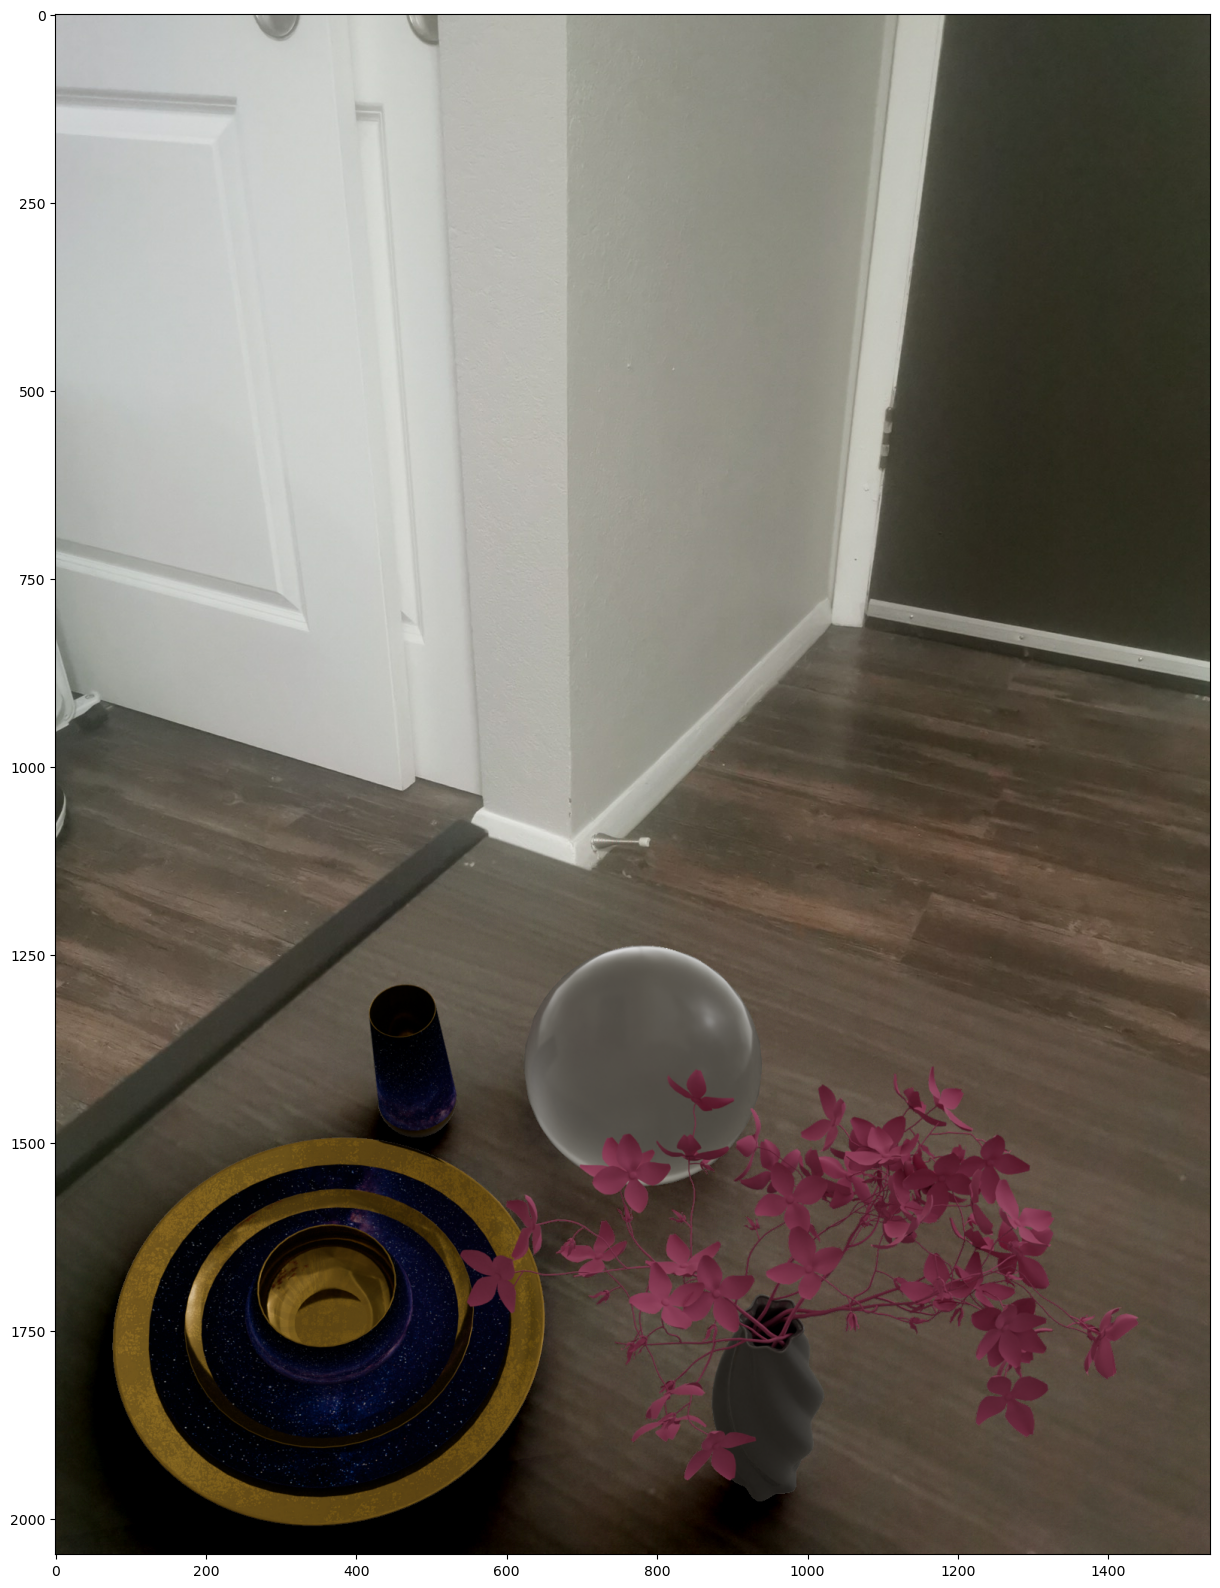

In [18]:
# compute final composite
result = []

#c for shadow
c = 3.0  
result = M * O + (1 - M) * I + (1 - M) * (O - E) * c
result = np.clip(result, 0, 1)

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite.png')

---


## Bells & Whistles (Extra Points)

### Additional Image-Based Lighting Result 




In [19]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/proj4_objects_2.png')
E = read_image('images/proj4_empty_2.png')
M = read_image('images/proj4_mask_2.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

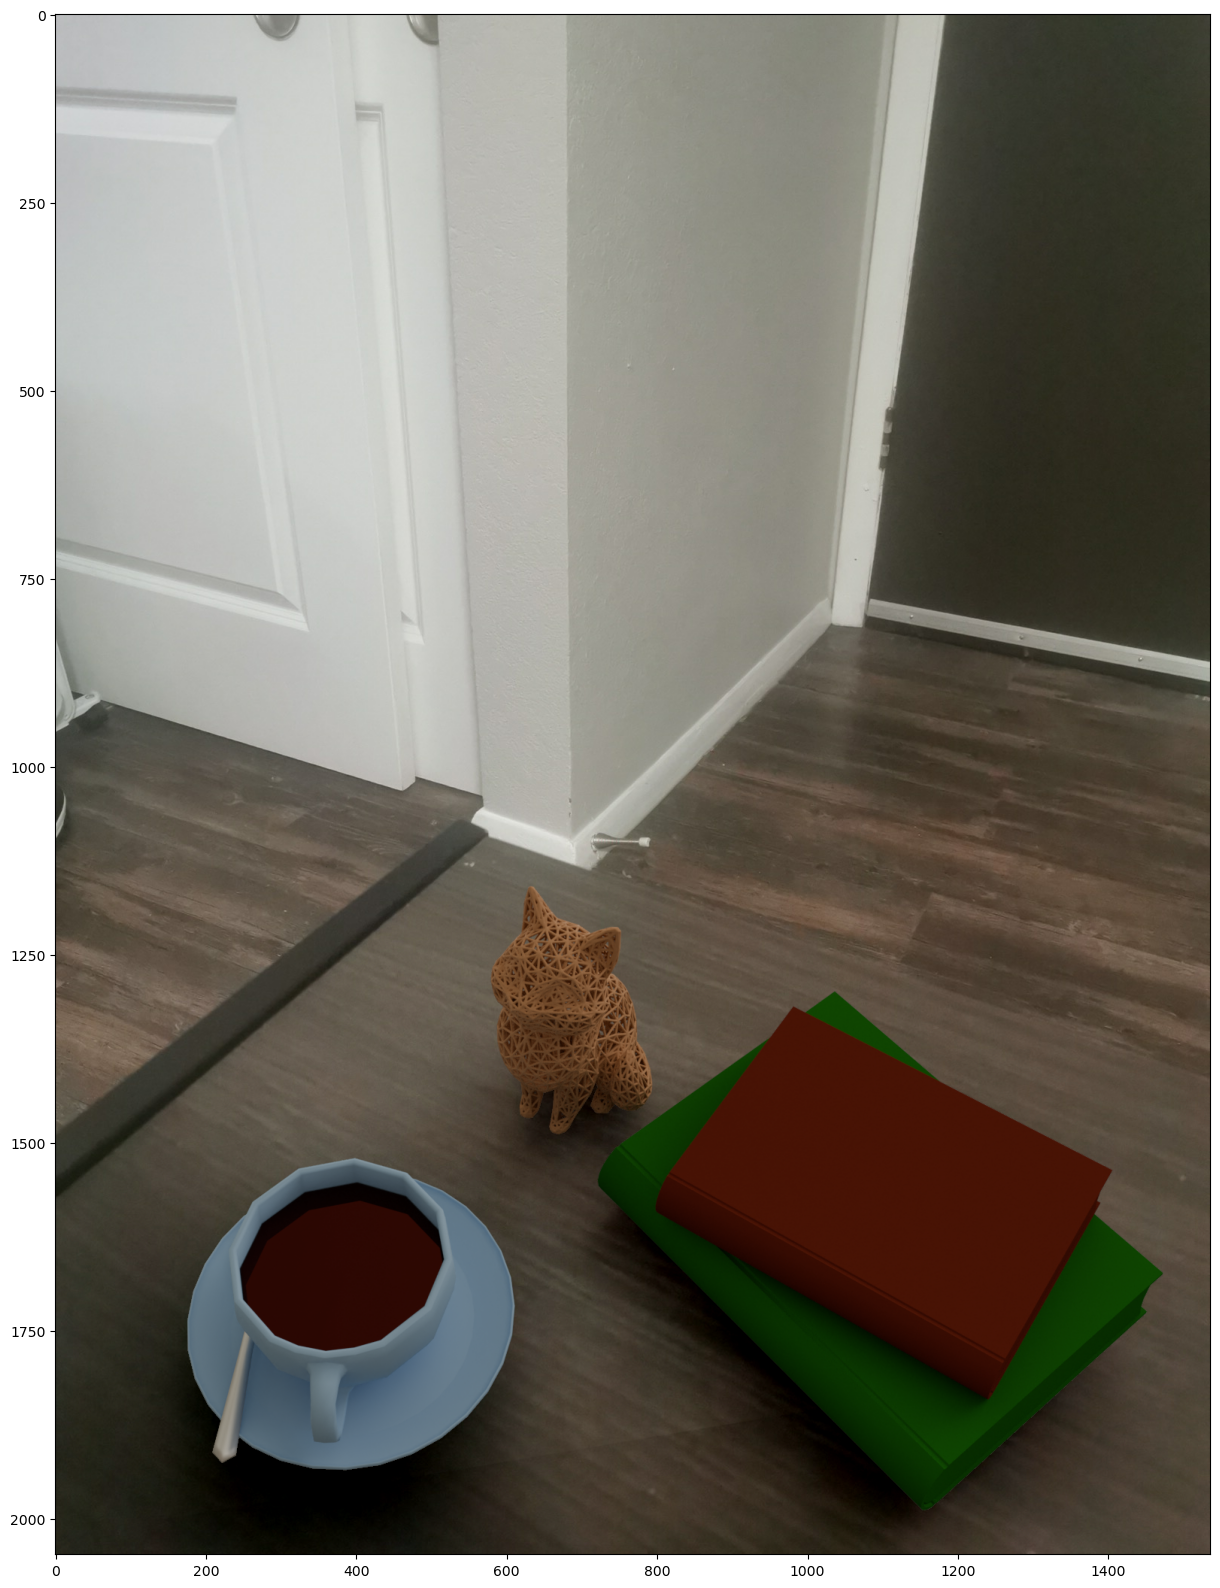

In [24]:
# compute final composite
result = []

#c for shadow
c = 1.5  
result = M * O + (1 - M) * I + (1 - M) * (O - E) * c
result = np.clip(result, 0, 1)

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite_2.png')

In [25]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/proj4_objects_3.png')
E = read_image('images/proj4_empty_3.png')
M = read_image('images/proj4_mask_3.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

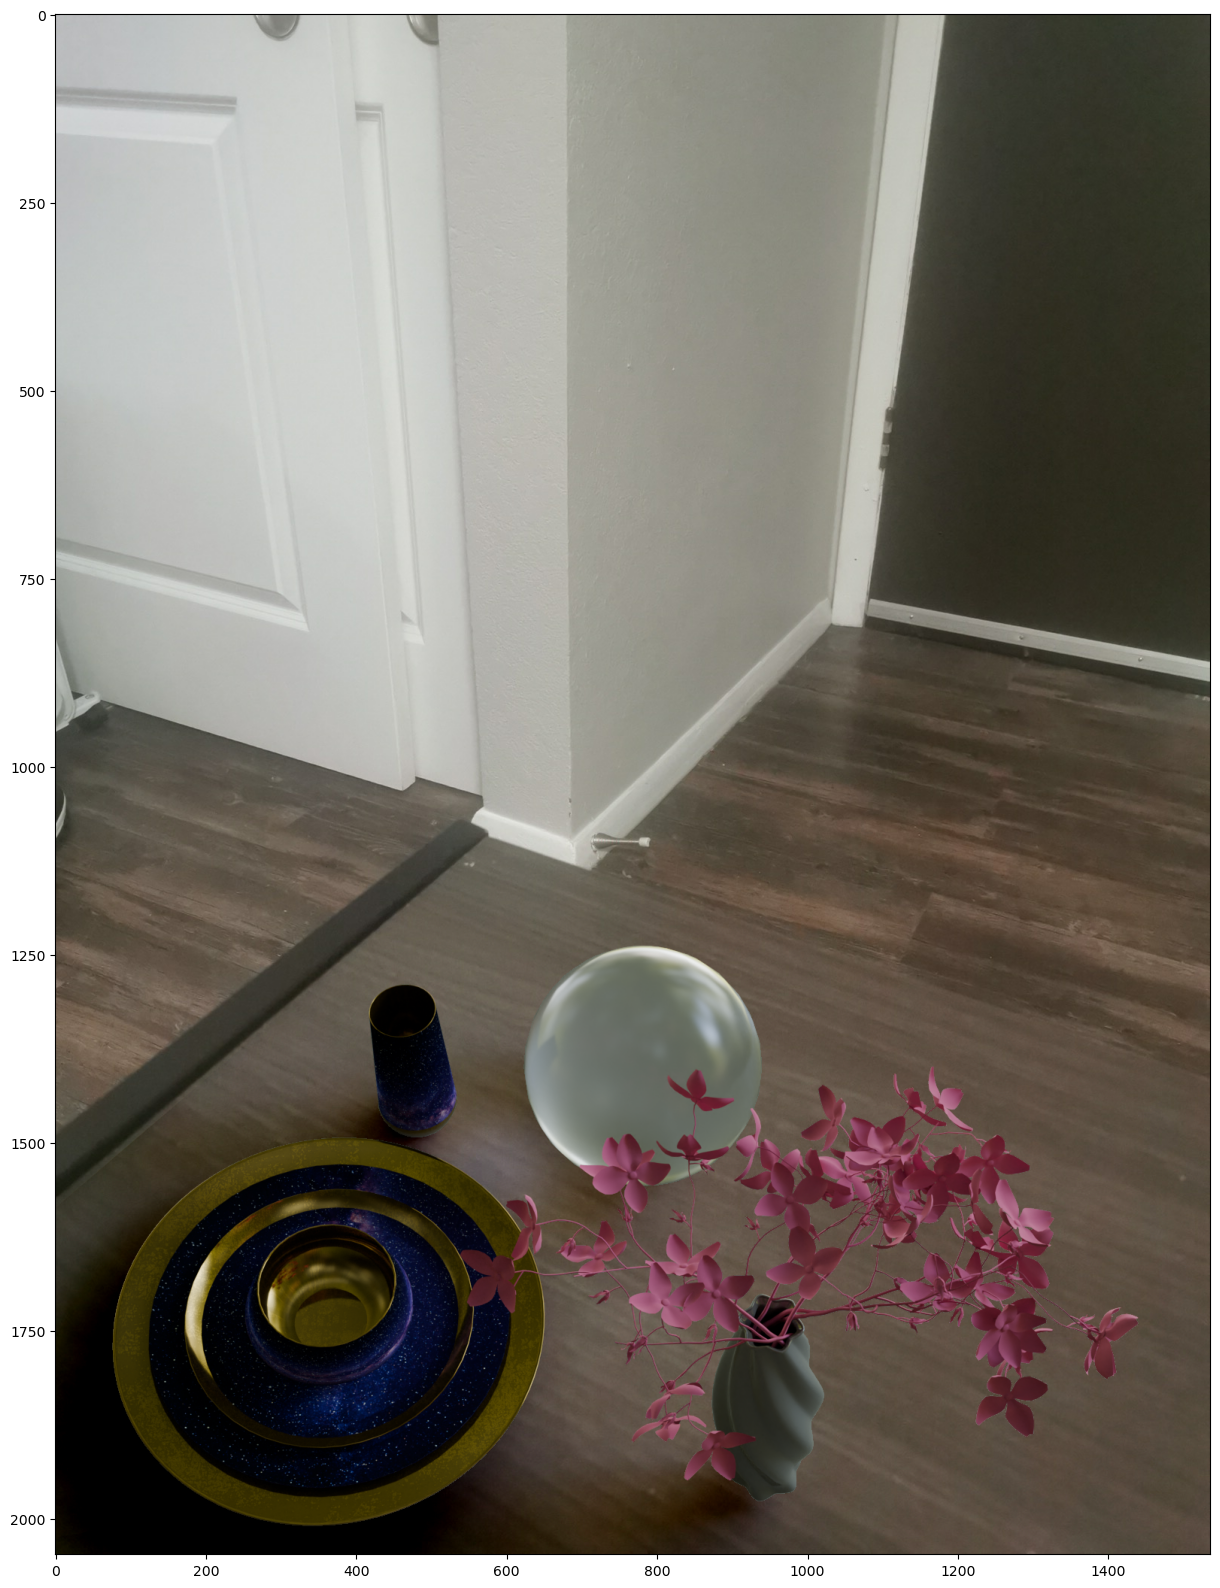

In [26]:
# compute final composite
result = []

#c for shadow
c = 1.5  
result = M * O + (1 - M) * I + (1 - M) * (O - E) * c
result = np.clip(result, 0, 1)

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite_3.png')